In [1]:
!pip install --upgrade pip
!pip install imblearn
!pip install scikit-optimize

Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 106.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/
  Using cached https://devpi.svc.ngsci.local/root/pypi/%2Bf/d42/c2d709d22c00d/imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached https://devpi.svc.ngsci.local/root/pypi/%2Bf/7eb/5859f7827cb3b/imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
INFO: pip is looking at multiple versions of imbalanced-learn to determine which version is compatible with other requirements. This could take a while.
  Using cached https://devpi.svc.ngsci.local/root/pypi/%2Bf/d47/fc599160d3ea8/imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imblearn]d-learn]
Looking in indexes: https://devpi.svc.ngsc

In [22]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from scipy.optimize import minimize
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier

#Import classifier libraries
from sklearn import svm
import itertools
import time
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [3]:
# Function to evaluate the model
def evaluate_model(model, X, y):
    """
    Calculate Evluation metrics for a given model and dataset.
    
    Parameters:
    model : sklearn model
        The trained model used to predict the labels.
    X : array-like or DataFrame
        The input data used for prediction.
    y : array-like or Series
        The true labels of the data.
    
    Returns:
    accuracy : float
        The Accuracy of the model.
    precision or PPV : float
        The Accuracy Precision or PPV the model.
    recall : float
        The Recall of the model.
    specificity : float
        The Specificity of the model.
    f1-score : float
        The f1-score of the model.
    auc_roc : float
        The auc_roc of the model.
    npv : float
        The Negative Predictive Value (NPV) of the model.
    """
    y_pred = model.predict(X)
    #y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    specificity = specificity_score(y, y_pred)
    
    f1 = f1_score(y, y_pred)
    npv = calculate_npv(y, y_pred)

    return accuracy, precision, recall, specificity, npv, f1

# Plot the AUC-ROC curve for each set
def plot_roc_curve(model, X, y, set_name):
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - ' + set_name)
    plt.legend(loc="lower right")
    plt.show()

    # Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {set_name}')
    plt.show()
    
def calculate_npv(y, y_pred):
    """
    Calculate the Negative Predictive Value (NPV) for a given model and dataset.
    
    Parameters:
    model : sklearn model
        The trained model used to predict the labels.
    X : array-like or DataFrame
        The input data used for prediction.
    y : array-like or Series
        The true labels of the data.
    
    Returns:
    npv : float
        The Negative Predictive Value (NPV) of the model.
    """
    
    # Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Calculate NPV
    npv = tn / (tn + fn)
    
    return npv 

def show_model_eval(model, X, y, data_type):
    metrics = evaluate_model(model, X, y)
    print("\n ",data_type, " Metrics:")
    print("Accuracy: {:.2f}".format(metrics[0]))
    print("Precision: {:.2f}".format(metrics[1]))
    print("Recall: {:.2f}".format(metrics[2]))
    print("Specificity: {:.2f}".format(metrics[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics[4]))
    print("F1-Score: {:.2f}".format(metrics[5]))
    
    #Plot Confusion Matrix
    y_pred = model.predict(X)
    plot_confusion_matrix(y, y_pred, data_type)

def print_train_val_metrics(metrics_train, metrics_val):
    print("Train Set Metrics")
    print("Accuracy: {:.2f}".format(metrics_train[0]))
    print("Precision: {:.2f}".format(metrics_train[1]))
    print("Recall: {:.2f}".format(metrics_train[2]))
    print("Specificity: {:.2f}".format(metrics_train[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics_train[4]))
    print("F1-Score: {:.2f}".format(metrics_train[5]))

    print("\nValidation Set Metrics:")
    print("Accuracy: {:.2f}".format(metrics_val[0]))
    print("Precision: {:.2f}".format(metrics_val[1]))
    print("Recall: {:.2f}".format(metrics_val[2]))
    print("Specificity: {:.2f}".format(metrics_val[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics_val[4]))
    print("F1-Score: {:.2f}".format(metrics_val[5]))
    
def print_cv_metrics(model,X,y,cv):
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    #caculate the metrics using cross validation
    for metric in metrics:
        score = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
        print(metric, ': mean %.3f and standard deviation (%.3f)' % (np.mean(score), np.std(score)))

    #find the specificity
    specificity = cross_val_score(model, X, y, scoring=make_scorer(recall_score, pos_label=0))
    print('specificity: mean %.3f and standard deviation (%.3f)' % (np.mean(specificity), np.std(specificity)))

    #find the npv
    npvs = cross_val_score(model, X, y, scoring=make_scorer(precision_score, pos_label=0))
    print('npv: mean %.3f and standard deviation (%.3f)' % (np.mean(npvs), np.std(npvs)))
    


In [4]:
#Read data
filter_dir = os.path.join('/','home','ngsci','project','csv_files_and_genarators')
data_positive_label = pd.read_csv(os.path.join(filter_dir,'data_OHCA_preECGs_w24h.csv'))
data_negative_label = pd.read_csv(os.path.join(filter_dir,'data_ctrg_preECGs_wNdays.csv'))

print(data_positive_label.shape)
print(data_negative_label.shape)

#Concatanete both datasets
dataset_df = pd.concat([data_negative_label,data_positive_label], ignore_index=True)

#Remove IDs
dataset_df = dataset_df.drop(columns=['ecg_id', 'patient_id'])


(19, 26)
(247, 26)


In [5]:
ran_num=2
#Apply SMOTE to minority class
X = dataset_df.drop('label', axis=1)  # Features
y = dataset_df['label']  # Labels

# Count the current number of labels
count_label_1 = sum(y == 1)

# Initialize SMOTE with the desired ratio
resampling_factor=3
smote = SMOTE(sampling_strategy={1: count_label_1*resampling_factor}, random_state=ran_num)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

#Standarize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Create a new dataframe with the resampled data
resampled_df = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

print("Original dataset shape:", dataset_df.shape)
print("Resampled dataset shape:", resampled_df.shape)
print("Original class distribution:\n", dataset_df['label'].value_counts())
print("Resampled class distribution:\n", resampled_df['label'].value_counts())

Original dataset shape: (266, 24)
Resampled dataset shape: (304, 24)
Original class distribution:
 label
0    247
1     19
Name: count, dtype: int64
Resampled class distribution:
 label
0    247
1     57
Name: count, dtype: int64


In [6]:
# Split the dataset into training, validation, and testing sets
train_df, val_df = train_test_split(resampled_df, test_size=0.3, random_state=ran_num)

# Define the features (X) and target (y)
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

Train Set Metrics
Accuracy: 0.85
Precision: 0.60
Recall: 0.69
Specificity: 0.89
Negative Predictive Value: 0.92
F1-Score: 0.64

Validation Set Metrics:
Accuracy: 0.90
Precision: 0.69
Recall: 0.73
Specificity: 0.94
Negative Predictive Value: 0.95
F1-Score: 0.71


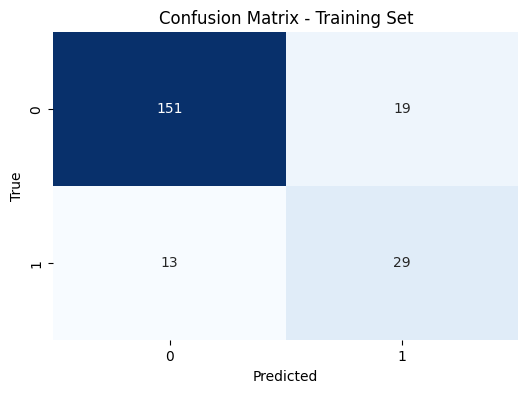

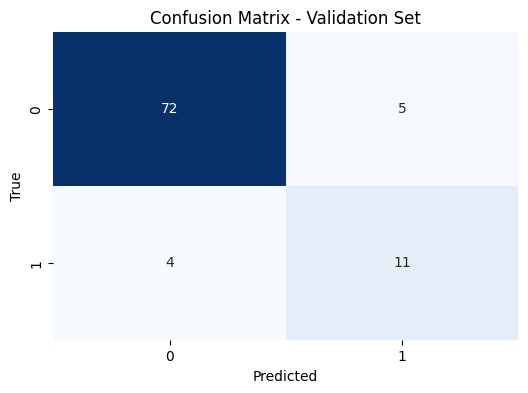

In [23]:
# Initialize the base model.
sgdc = SGDClassifier(alpha=0.01,
                     class_weight='balanced',
                     early_stopping=True,
                      l1_ratio=0.1, loss='huber',
                     penalty='elasticnet',
                      random_state=42) #New

# Initialize the Bagging classifier
model = BaggingClassifier(estimator=sgdc,
                        n_estimators=10,                  #(10 to 30) 
                          max_samples = 0.65,            #[0.3 to 1.0]
                          max_features = 0.75,           #[0.5 to 1.0]
                          bootstrap = False,             #[False, True]
                          bootstrap_features = True,    #[False, True]
                          random_state=ran_num)

model.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
metrics_train = evaluate_model(model, X_train, y_train)
metrics_val = evaluate_model(model, X_val, y_val)

# Print the metrics
print_train_val_metrics(metrics_train, metrics_val)
    
#Plot Confusion Matrix Training Set
y_train_pred = model.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred, 'Training Set')

#Plot Confusion Matrix Validation Set
y_val_pred = model.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')


In [24]:
#Define everything for CV searching
inner_folds = 3
outer_folds = 5

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=ran_num)
cv_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=ran_num)

#Hyperparameteres to tune: 
# define search space
space = {
    'n_estimators': [10, 20, 25, 30],
    'max_samples': [0.3, 0.5, 0.8, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    #'bootstrap': [False, True],
    #'bootstrap_features': [False, True],
    #'oob_score': [False, True],
    }

# define the model
models = BaggingClassifier(estimator=sgdc,
                          random_state=ran_num)
# define search
search = GridSearchCV(models, space, scoring='f1', n_jobs=1, cv=cv_inner, refit=True)

In [25]:
start = time.perf_counter()

# Perform nested cross-validation
outer_F1 = []
outer_Pre = []
outer_Sens = []
outer_Spec = []
outer_Acc = []
outer_NPV = []

for train_idx, test_idx in cv_outer.split(X_scaled, y_resampled):
    X_cv_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_cv_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    
    search.fit(X_cv_train, y_cv_train)

    # Train the model with the best hyperparameters on the outer training fold
    best_model = search.best_estimator_
    best_model.fit(X_cv_train, y_cv_train)

    # Evaluate the model on the outer validation fold
    y_pred = best_model.predict(X_test)
    outer_F1.append(f1_score(y_test, y_pred))
    print(outer_F1)
    outer_Pre.append(precision_score(y_test, y_pred))
    outer_Sens.append(recall_score(y_test, y_pred))
    outer_Acc.append(accuracy_score(y_test, y_pred))
    outer_Spec.append(specificity_score(y_test, y_pred))
    npv = calculate_npv(y_test, y_pred)
    outer_NPV.append(npv)
    
# Report the mean and standard deviation of the scores across the outer folds
#print(f"F1 nested cross-validation scores: {outer_scores}")
print(f"F1 mean score: {np.mean(outer_F1):.3f} +/- {np.std(outer_F1):.3f}")
print(f"Precision mean: {np.mean(outer_Pre):.3f} +/- {np.std(outer_Pre):.3f}")
print(f"Sensitivity mean: {np.mean(outer_Sens):.3f} +/- {np.std(outer_Sens):.3f}")
print(f"Specificity mean: {np.mean(outer_Spec):.3f} +/- {np.std(outer_Spec):.3f}")
print(f"NPV mean: {np.mean(outer_NPV):.3f} +/- {np.std(outer_NPV):.3f}")
print(f"Accuracy mean: {np.mean(outer_Acc):.3f} +/- {np.std(outer_Acc):.3f}")

end = time.perf_counter()
print(f"Time taken: {(end - start)/60:.2f} minutes")

/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 472, in _fit
    all_results = Para

[0.5833333333333334]


/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 472, in _fit
    all_results = Para

[0.5833333333333334, 0.761904761904762]


/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 472, in _fit
    all_results = Pa

[0.5833333333333334, 0.761904761904762, 0.8]


/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 472, in _fit
    all_results = Pa

[0.5833333333333334, 0.761904761904762, 0.8, 0.6666666666666667]


/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py", line 472, in _fit
    all_results = Pa

[0.5833333333333334, 0.761904761904762, 0.8, 0.6666666666666667, 0.761904761904762]
F1 mean score: 0.715 +/- 0.079
Precision mean: 0.693 +/- 0.120
Sensitivity mean: 0.752 +/- 0.075
Specificity mean: 0.915 +/- 0.049
NPV mean: 0.942 +/- 0.014
Accuracy mean: 0.885 +/- 0.040
Time taken: 2.17 minutes


In [26]:
#Find the best model using Bayesian optimization
start = time.perf_counter()
# The search_space can now be passed to BayesSearchCV
# the model is model
print(model)

# Define the search space
search_space = {
    'n_estimators': Integer(10, 30),
    'max_samples': Real(0.3, 1.0),
    'max_features': Real(0.5, 1.0),
 #   'bootstrap': Categorical([False, True]),
 #   'bootstrap_features': Categorical([False, True]),
    }

# Create the Bayesian optimization object
optimizer = BayesSearchCV(
    model,
    search_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='f1',
    random_state=ran_num
)

# Fit the optimizer to the data
optimizer.fit(X_resampled, y_resampled)

# Print the best hyperparameters and score
print("Best hyperparameters:", optimizer.best_params_)
print("Best score:", optimizer.best_score_)

end = time.perf_counter()
print(f"Time taken: {(end - start)/60:.2f} minutes")

BaggingClassifier(bootstrap=False, bootstrap_features=True,
                  estimator=SGDClassifier(alpha=0.01, class_weight='balanced',
                                          early_stopping=True, l1_ratio=0.1,
                                          loss='huber', penalty='elasticnet',
                                          random_state=42),
                  max_features=0.75, max_samples=0.65, random_state=2)
Best hyperparameters: OrderedDict([('max_features', 0.5625506085784284), ('max_samples', 0.43806470513443674), ('n_estimators', 21)])
Best score: 0.37833365753811155
Time taken: 1.88 minutes


In [27]:
#Test the best model found 
best_BScv = optimizer.best_estimator_

#Test best score in training

print_cv_metrics(best_BScv, X_scaled, y_resampled, cv_outer)

accuracy : mean 0.839 and standard deviation (0.020)
precision : mean 0.556 and standard deviation (0.057)
recall : mean 0.736 and standard deviation (0.121)
f1 : mean 0.628 and standard deviation (0.057)
specificity: mean 0.847 and standard deviation (0.080)
npv: mean 0.929 and standard deviation (0.032)


# END